In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [28]:
%cd /content/gdrive/MyDrive/Colab Notebooks/CoCrNi_simulated_data

/content/gdrive/MyDrive/Colab Notebooks/CoCrNi_simulated_data


In [29]:
pip install fast-histogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import pandas as pd
import random as rd
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from fast_histogram import histogram2d as fast_histogram2d 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import math
import os
import shutil

Function: Euler_transformation

In [31]:
def Euler_transformation_100(data_clean, plot):
    #%% Plot 3D crystal structure without duplicates
    data_110 = data_clean
    if plot == True:
        df = pd.DataFrame(data_clean,columns=['a','b','c','d'])
        group_1 = df[df.d==56].values
        group_2 = df[df.d==24].values
        fig = plt.figure()
        ax = plt.subplot(111, projection='3d')  # build a project
        ax.scatter(data_clean [:, 0], data_clean [:, 1], data_clean [:, 2], c=data_clean [:, 3], s=8)  # 绘制数据点
        #ax.plot(group_1 [:, 0], group_1 [:, 2], 'p', zdir = 'y', label = 'Al')    #divide it into different parts
        #ax.plot(group_2 [:, 0], group_2 [:, 2], 'o', zdir = 'y', label = 'Mg')    #divide it into different parts
        
        # plt.legend(loc='upper right')
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_zlabel('Z', fontsize=16)  # axis
        ax.set_ylabel('Y', fontsize=16)
        ax.set_xlabel('X', fontsize=16)
        plt.show()
    return data_110
#%%
def Euler_transformation_110(data_clean, plot):
    #%%  change pole from 100 to 110
    row = data_clean.shape[0]
    data_110 = np.empty([row,4], dtype = float)
    data_110[:,3] = data_clean[:,3]
    
    ##rotate along x axis
    #data_110[:,0] = data_sample[:,0]
    #data_110[:,1] = (data_sample[:,1]+data_sample[:,2])*math.sqrt(2)/2.0
    #data_110[:,2] = (data_sample[:,1]+data_sample[:,2])*math.sqrt(2)/2.0
    
    #rotate along y axis
    data_110[:,0] = (data_clean[:,0]-data_clean[:,2])*math.sqrt(2)/2.0
    data_110[:,1] = data_clean[:,1]
    data_110[:,2] = (data_clean[:,0]+data_clean[:,2])*math.sqrt(2)/2.0
    
    ##rotate along Z axis
    #data_110[:,0] = (data_sample[:,0]+data_sample[:,1])*math.sqrt(2)/2.0
    #data_110[:,1] = (-data_sample[:,0]+data_sample[:,1])*math.sqrt(2)/2.0
    #data_110[:,2] = data_sample[:,2]
    #%% Plot 3D crystal structure 011
    if plot == True:
        df = pd.DataFrame(data_110,columns=['a','b','c','d'])
        group_1 = df[df.d==56].values
        group_2 = df[df.d==24].values
        
        fig = plt.figure()
        ax = plt.subplot(111, projection='3d')  # build a project
        ax.scatter(data_110 [:, 0], data_110 [:, 1], data_110 [:, 2],c=data_110 [:, 3], s=8)  # 绘制数据点
        #ax.plot(group_1 [:, 0], group_1 [:, 2], 'p', zdir = 'y', label = 'Al')    #divide it into different parts
        #ax.plot(group_2 [:, 0], group_2 [:, 2], 'o', zdir = 'y', label = 'Mg')    #divide it into different parts
        
        # plt.legend(loc='upper right')
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_zlabel('Z', fontsize=16)  # axis
        ax.set_ylabel('Y', fontsize=16)
        ax.set_xlabel('X', fontsize=16)
        plt.show()
    #%%
    return data_110
#%%
def Euler_transformation_111(data_clean, plot):
    #%%  change pole from 111 to 001
    row = data_clean.shape[0]
    data_111 = np.empty([row,4], dtype = float)
    data_111[:,3] = data_clean[:,3]
    
    #rotate [111]
    data_111[:,0] = data_clean[:,0]*0.408248 + data_clean[:,1]*0.408248 + data_clean[:,2]*(-0.816497)
    data_111[:,1] = data_clean[:,0]*(-0.707107) + data_clean[:,1]*0.707107 + data_clean[:,2]*(0.0)
    data_111[:,2] = data_clean[:,0]*0.57735 + data_clean[:,1]*(0.57735) + data_clean[:,2]*(0.57735)
    
    data_110 = data_111
    #%% Plot 3D crystal structure 111
    if plot == True:  
        df = pd.DataFrame(data_110,columns=['a','b','c','d'])
        group_1 = df[df.d==56].values  #Al
        group_2 = df[df.d==7].values  #Li
        group_3 = df[df.d==24].values   #Mg
        
        fig = plt.figure()
        ax = plt.subplot(111, projection='3d')  # build a project
        
        ax.scatter(data_110 [:, 0], data_110 [:, 1], data_110 [:, 2],c=data_110 [:, 3], s=8)  # 绘制数据点
        
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_zlabel('Z', fontsize=16)  # axis
        ax.set_ylabel('Y', fontsize=16)
        ax.set_xlabel('X', fontsize=16)
        plt.show()
    #%%
    return data_110
#%%

Function: generator_single_SDMs

In [32]:
def single_SDMs(data_reconstruction, el_number, sigma_xy, sigma_z, plot_noise, detect_eff, atomic_number_1, atomic_number_2, lattice_para, image_name_1, image_name_2, save_XZSDM, plot_XZSDM, save_ZSDM, plot_ZSDM):
    mu  = 0
    SDM_bins = 200   #define pixel density 
   #%% adding noise with the same dimension as 'data_clean'
    row = data_reconstruction.shape[0]
    noise_xy = np.random.normal(mu, sigma_xy, [row ,2]) 
    noise_z = np.random.normal(mu, sigma_z, [row ,1])
    zeros = np.zeros((row, 1))
    noise = np.hstack((noise_xy, noise_z, zeros))
    data_noise = data_reconstruction + noise
    #%% Plot 3D crystal structure with noise
    if plot_noise == True:
        ax = plt.subplot(111, projection='3d')  # build a project
        ax.scatter(data_noise [:, 0], data_noise [:, 1], data_noise [:, 2], c=data_noise [:, 3], cmap='turbo', s=8)  # 绘制数据点
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_zlabel('Z (nm)', fontsize=16)  # axis
        ax.set_ylabel('Y (nm)', fontsize=16)
        ax.set_xlabel('X (nm)', fontsize=16)
        plt.show()
    #%%Plot Gaussian distributions
#    count, bins, ignored = plt.hist(noise_z[:,0], 30, density=True)
#    plt.plot(bins, 1/(sigma_z * np.sqrt(2 * np.pi)) *
#             np.exp( - (bins - mu)**2 / (2 * sigma_z**2) ),linewidth=2, color='r')
#    plt.show()
    #%% Detect efficiency
    #Data random sequence
    data_no_shuffle = data_noise     #110   #no noise
    row = data_no_shuffle.shape[0]
    idx = rd.sample(range(row),row) 
    data_shuffle = data_no_shuffle[idx]

    data_sample = data_shuffle[:int(row*detect_eff), :]
    if plot_noise == True:
        ax = plt.subplot(111, projection='3d')  # build a project
        ax.scatter(data_sample [:, 0], data_sample [:, 1], data_sample [:, 2], c=data_sample [:, 3], cmap='turbo', s=8)  # plot data points
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_zlabel('Z (nm)', fontsize=16)  # axis
        ax.set_ylabel('Y (nm)', fontsize=16)
        ax.set_xlabel('X (nm)', fontsize=16)
        plt.show()
    data = data_sample
    row_number = data.shape[0]
    #%% Finding element 1 and element 2
    df = pd.DataFrame(data,columns=['a','b','c','d'])
    
#   print('element_number=', el_number)
    if el_number == 0:
        element_1 = df.loc[(df['d'] == atomic_number_1 ) , ['a','b','c']]   
        element_1 = element_1.values
    else:
        element_2 = df.loc[(df['d'] == atomic_number_2 ) , ['a','b','c']]  
        element_1 = element_2.values
    #Note to use & or | to replace and/or.
        
    #%% generating SDMs
    tree = []
    tree = spatial.cKDTree(element_1)
    SDM = np.zeros([SDM_bins,SDM_bins])
    x_tot = [];
    y_tot = [];
    num_in_SDM = 0;
    max_cand =0
    # cand = tree.query_ball_point(element_1, 1.5,return_sorted=False, n_jobs = -1)
    cand = tree.query_ball_point(element_1, 1.5,return_sorted=False)
    for list in cand:
        num_in_SDM += len(list);
        if (len(list) > max_cand):
            max_cand = len(list);
    x_tot = np.zeros([num_in_SDM,], dtype = np.float32)
    y_tot = np.zeros([num_in_SDM,], dtype = np.float32)
    x = np.zeros([max_cand,], dtype = np.float32)   
    y = np.zeros([max_cand,], dtype = np.float32)   
    
    start = 0;
    i = 0;
    for list in cand:
        length = len(list)
        x_tot[start:(start+length)] = np.ndarray.__sub__(element_1[list,0],element_1[i,0]);
        y_tot[start:(start+length)] = np.ndarray.__sub__(element_1[list,2],element_1[i,2]);
        i += 1
        start = start+length;
    notzero = (x_tot!=0)*(y_tot!=0);
    SDM = fast_histogram2d(y_tot[notzero],x_tot[notzero], range = [[-1.5,1.5],[-1.5,1.5]],  bins=SDM_bins)   
    #%%Save hisgram xz-SDM 
    if save_XZSDM == True:
        xedges = np.linspace(-1.5, 1.5, num=SDM_bins+1, endpoint=True, retstep=False, dtype=np.float32)
        yedges = np.linspace(-1.5, 1.5, num=SDM_bins+1, endpoint=True, retstep=False, dtype=np.float32)
        fig2D = plt.figure(figsize=(4,4))
        ax2D = fig2D.add_subplot(111)
        levels = MaxNLocator(nbins=8).tick_values(1, SDM.max())
        if el_number == 0:
            cmap = plt.get_cmap('BuGn') # jet
        else:
            cmap = plt.get_cmap('Blues')
        
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)   
        im=ax2D.pcolormesh(yedges, xedges, SDM, cmap=cmap, norm=norm)                             
    
        ax2D.set_aspect(1)
        plt.xlim((-0.7,0.7))
        plt.ylim((-0.7,0.7))
        ax2D.set_xticks([])
        ax2D.set_yticks([])
        plt.axis('off')
        plt.subplots_adjust(0,0,1,1)
        # plt.show() 
        plt.close()   
        if el_number == 0:
            fig2D.savefig('Results_ZXSDMs\Simu_'+image_name_1+'_a_%.3f_de_%.2f_noise_z_%.3f_noise_xy_%.2f.png'%(lattice_para, detect_eff, sigma_z, sigma_xy),dpi=SDM_bins)
        else:
            fig2D.savefig('Results_ZXSDMs\Simu_'+image_name_2+'_a_%.3f_de_%.2f_noise_z_%.3f_noise_xy_%.2f.png'%(lattice_para, detect_eff, sigma_z, sigma_xy),dpi=SDM_bins)        
    #%%Plot hisgram xz-SDM
    if plot_XZSDM == True:
        xedges = np.linspace(-1.5, 1.5, num=SDM_bins+1, endpoint=True, retstep=False, dtype=np.float32)
        yedges = np.linspace(-1.5, 1.5, num=SDM_bins+1, endpoint=True, retstep=False, dtype=np.float32)
        fig2D = plt.figure(figsize=(4,4))
        ax2D = fig2D.add_subplot(111)
        levels = MaxNLocator(nbins=8).tick_values(1, SDM.max())
        if el_number == 0:
            cmap = plt.get_cmap('jet') #BuGn
        else:
            cmap = plt.get_cmap('Blues')
        
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)   
        im=ax2D.pcolormesh(yedges, xedges, SDM, cmap=cmap, norm=norm)  
        ax2D.set_xlabel('$\Delta$x, nm', fontsize=20)
        ax2D.set_ylabel('$\Delta$z, nm', fontsize=20)
        print('element_number=', el_number)
        ax2D.set_aspect(1)
        plt.xlim((-0.7,0.7))
        plt.ylim((-0.7,0.7))
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        cb = fig2D.colorbar(im,ax=ax2D)
        cb.ax.tick_params(labelsize=18)
        plt.show()  
    #%%plot z-SDMs curve
    if plot_ZSDM == True:       
        y_zSDM = SDM.sum(axis=1).reshape((200, 1))
        # sum_y_zSDM = sum(y_zSDM)
        # y_fre = y_zSDM/sum_y_zSDM*100
        # y_fre = np.array(y_fre).reshape((len(y_fre), 1))
                
        # # scaler = StandardScaler()
        # scaler = MinMaxScaler() 
        # scaler.fit(y_fre)
        # y_fre_scale = scaler.transform(y_fre)          #normalization
        
        x_zSDM = np.arange(-1.5, 1.5, 3/200).reshape((200, 1))
        # zSDM_simu = np.zeros((200, 1))
        zSDM_simu = np.concatenate((x_zSDM, y_zSDM), axis=1)
        zSDM_simu_index = np.where((zSDM_simu[:,0]>=-0.7) & (zSDM_simu[:,0]<0.7))
        zSDM_simu_index_array = np.array(zSDM_simu_index).reshape(-1, 1)
        zSDM_simu_part = zSDM_simu[zSDM_simu_index_array[0, 0]:zSDM_simu_index_array[-1, 0]+1, ]
        
        fig2D = plt.figure(figsize=(4,4))                
        ax2D = fig2D.add_subplot(111)   
        plt.plot(zSDM_simu_part[: ,0], zSDM_simu_part[: ,1])
        # ax2D.set_aspect(1)
        plt.xlim((-0.7,0.7))
        # plt.ylim((0.0,1.0))
        # ax2D.set_xticks([])
        # ax2D.set_yticks([])
        # plt.axis('off')
        # plt.subplots_adjust(0,0,1,1) 
        return zSDM_simu_part
    #%% save z-SDMs curve
    if save_ZSDM == True:   
        y_zSDM = SDM.sum(axis=1).reshape((200, 1))
        # sum_y_zSDM = sum(y_zSDM)
        # y_fre = y_zSDM/sum_y_zSDM*100
        # y_fre = np.array(y_fre).reshape((len(y_fre), 1))
                
        # # scaler = StandardScaler()
        # scaler = MinMaxScaler() 
        # scaler.fit(y_fre)
        # y_fre_scale = scaler.transform(y_fre)          #normalization
        
        x_zSDM = np.arange(-1.5, 1.5, 3/200).reshape((200, 1))
        # zSDM_simu = np.zeros((200, 1))
        zSDM_simu = np.concatenate((x_zSDM, y_zSDM), axis=1)
        zSDM_simu_index = np.where((zSDM_simu[:,0]>=-0.7) & (zSDM_simu[:,0]<0.7))
        zSDM_simu_index_array = np.array(zSDM_simu_index).reshape(-1, 1)
        zSDM_simu_part = zSDM_simu[zSDM_simu_index_array[0, 0]:zSDM_simu_index_array[-1, 0]+1, ]
        
        fig2D = plt.figure(figsize=(4,4))                
        ax2D = fig2D.add_subplot(111)   
        plt.plot(zSDM_simu_part[: ,0], zSDM_simu_part[: ,1])
        # ax2D.set_aspect(1)
        plt.xlim((-0.7,0.7))
        # plt.ylim((0.0,1.0))       
        # ax2D.set_xticks([])
        # ax2D.set_yticks([])
        # plt.axis('off')
        # plt.subplots_adjust(0,0,1,1)  
        plt.close()   
        if el_number == 0:
            fig2D.savefig('Results_ZSDMs\Simu_ZSDM_'+image_name_1+'_a_%.3f_de_%.2f_noise_z_%.3f_noise_xy_%.2f.png'%(lattice_para, detect_eff, sigma_z, sigma_xy),dpi=SDM_bins)
        else:
            fig2D.savefig('Results_ZSDMs\Simu_ZSDM_'+image_name_2+'_a_%.3f_de_%.2f_noise_z_%.3f_noise_xy_%.2f.png'%(lattice_para, detect_eff, sigma_z, sigma_xy),dpi=SDM_bins)    
        return zSDM_simu_part

    else:       
        y_zSDM = SDM.sum(axis=1).reshape((200, 1))
        # sum_y_zSDM = sum(y_zSDM)
        # y_fre = y_zSDM/sum_y_zSDM*100
        # y_fre = np.array(y_fre).reshape((len(y_fre), 1))
                
        # # scaler = StandardScaler()
        # scaler = MinMaxScaler() 
        # scaler.fit(y_fre)
        # y_fre_scale = scaler.transform(y_fre)          #normalization
        
        x_zSDM = np.arange(-1.5, 1.5, 3/200).reshape((200, 1))
        # zSDM_simu = np.zeros((200, 1))
        zSDM_simu = np.concatenate((x_zSDM, y_zSDM), axis=1)
        zSDM_simu_index = np.where((zSDM_simu[:,0]>=-0.7) & (zSDM_simu[:,0]<0.7))
        zSDM_simu_index_array = np.array(zSDM_simu_index).reshape(-1, 1)
        zSDM_simu_part = zSDM_simu[zSDM_simu_index_array[0, 0]:zSDM_simu_index_array[-1, 0]+1, ] 
        return zSDM_simu_part

Main part

Generating_ZSDMs_FCC_CoCo

sigma_xy= 0.3
sigma_z= 0.042
detect_eff is 0.44999999999999996
sigma_xy= 0.44999999999999996
sigma_z= 0.026000000000000002
detect_eff is 0.25
sigma_xy= 0.5499999999999999
sigma_z= 0.058
detect_eff is 0.5499999999999999
sigma_xy= 0.7
sigma_z= 0.042
detect_eff is 0.35


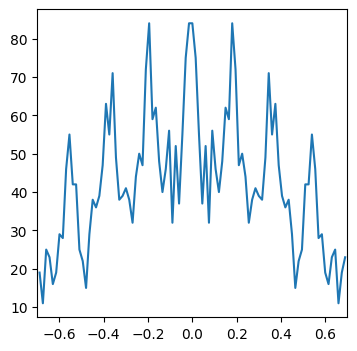

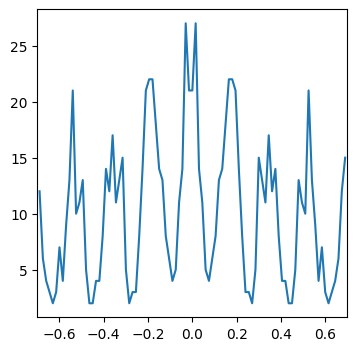

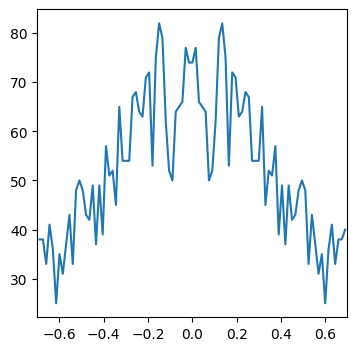

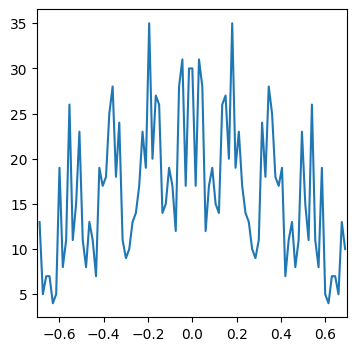

In [35]:
#%% Input file and parameters
data = np.loadtxt('ggoutputFile_FCC_CoCrNi_1nm_a_0.36.txt')
lattice_para = 0.36

sigma_xy_all = np.arange(0.2,0.8,0.05)
sigma_z_all = np.arange(0.01,0.06,0.002)
detect_eff_array = np.arange(0.2,0.7,0.05)

atomic_number_1 = 59  #Co
atomic_number_2 = 64  #others
save_XZSDM, save_ZSDM, plot_XZSDM, plot_ZSDM, plot_noise = False, False, False, False, False
Delete_folder = True  #default
image_name_1 = "CoCrNi_FCC_CoCo"#Co has 2 times space than others
image_name_2 = "CoCrNi_FCC_others"
#%% clean ouptfile contents
if Delete_folder == True:
    try:
        shutil.rmtree('Results_ZXSDMs') 
        shutil.rmtree('Results_ZSDMs')
    except:
        print("file does not exist")
    os.mkdir('Results_ZXSDMs') 
    os.mkdir('Results_ZSDMs')
#%% Remove all duplicates    
data_clean = np.unique(data, axis=0)
#%% Euler_transformation
data_reconstruction = Euler_transformation_100(data_clean, False)
# data_reconstruction = Euler_transformation_110(data_clean, False)
# data_reconstruction = Euler_transformation_111(data_clean, False)
#%% Add Gaussian noise
zSDM_simu_0 = np.zeros((int(0.69/0.015*2+1), 1))
zSDM_simu_1 = np.zeros((int(0.69/0.015*2+1), 1))
cycle_number = 0
for sigma_xy in sigma_xy_all:
    for sigma_z in sigma_z_all:
        for detect_eff in detect_eff_array:  
            for el_number in range(1):
                cycle_number = cycle_number + 1
                if  cycle_number%666 == 0:
                    print('sigma_xy=',sigma_xy)
                    print('sigma_z=',sigma_z)
                    print ('detect_eff is', detect_eff)
                    zSDM_simu_part = single_SDMs(data_reconstruction, el_number, sigma_xy, sigma_z, plot_noise, detect_eff, 
                                                 atomic_number_1, atomic_number_2, lattice_para, image_name_1, image_name_2, save_XZSDM, plot_XZSDM, save_ZSDM, plot_ZSDM=True)
                    if el_number==0:
                        zSDM_simu_0 = np.concatenate((zSDM_simu_0, zSDM_simu_part), axis=1)
                    else:
                        zSDM_simu_1 = np.concatenate((zSDM_simu_1, zSDM_simu_part), axis=1)
                    continue
                    print('---->>')
                    
                zSDM_simu_part = single_SDMs(data_reconstruction, el_number, sigma_xy, sigma_z, plot_noise, detect_eff, 
                                             atomic_number_1, atomic_number_2, lattice_para, image_name_1, image_name_2, save_XZSDM, plot_XZSDM, save_ZSDM, plot_ZSDM=False)
                if el_number==0:
                    zSDM_simu_0 = np.concatenate((zSDM_simu_0, zSDM_simu_part), axis=1)
                else:
                    zSDM_simu_1 = np.concatenate((zSDM_simu_1, zSDM_simu_part), axis=1)
                    
zSDM_simu_0 = zSDM_simu_0[:,1:]
zSDM_simu_1 = zSDM_simu_1[:,1:]
#%%save
np.save ("zSDM_simu_"+image_name_1, zSDM_simu_0)
# np.save ("zSDM_simu_"+image_name_2, zSDM_simu_1)

Generating_ZSDMs_CSRO_CoCo

sigma_xy= 0.3
sigma_z= 0.025999999999999995
detect_eff is 0.3
sigma_xy= 0.39999999999999997
sigma_z= 0.03199999999999999
detect_eff is 0.44999999999999996
sigma_xy= 0.49999999999999994
sigma_z= 0.037999999999999985
detect_eff is 0.5999999999999999
sigma_xy= 0.5999999999999999
sigma_z= 0.04599999999999998
detect_eff is 0.25
sigma_xy= 0.7499999999999998
sigma_z= 0.022
detect_eff is 0.39999999999999997


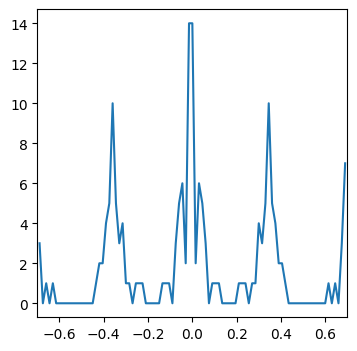

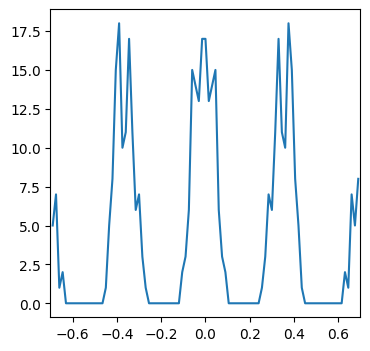

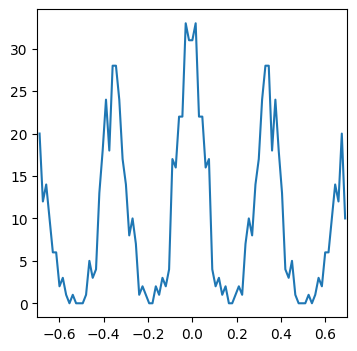

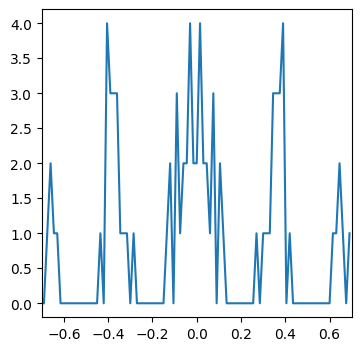

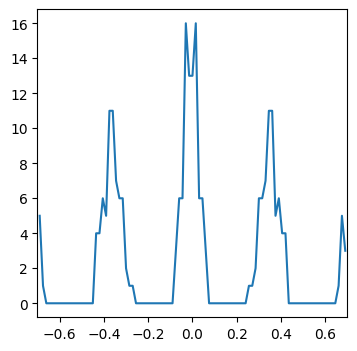

In [37]:
#%% Input file and parameters
data = np.loadtxt('ggoutputFile_L12_X3Co_1nm_a_0.36.txt')
lattice_para = 0.36

sigma_xy_all = np.arange(0.2,0.8,0.05)
sigma_z_all = np.arange(0.02,0.05,0.002)
detect_eff_array = np.arange(0.2,0.7,0.05)

atomic_number_1 = 59  #Co
atomic_number_2 = 64  #others
save_XZSDM, save_ZSDM, plot_XZSDM, plot_ZSDM, plot_noise = False, False, False, False, False
Delete_folder = True  #default
image_name_1 = "CoCrNi_L12_CoCo"#Co has 2 times space than others
image_name_2 = "CoCrNi_L12_others"
#%% clean ouptfile contents
if Delete_folder == True:
    try:
        shutil.rmtree('Results_ZXSDMs') 
        shutil.rmtree('Results_ZSDMs')
    except:
        print("file does not exist")
    os.mkdir('Results_ZXSDMs') 
    os.mkdir('Results_ZSDMs')
#%% Remove all duplicates    
data_clean = np.unique(data, axis=0)
#%% Euler_transformation
data_reconstruction = Euler_transformation_100(data_clean, False)
# data_reconstruction = Euler_transformation_110(data_clean, False)
# data_reconstruction = Euler_transformation_111(data_clean, False)
#%% Add Gaussian noise
zSDM_simu_0 = np.zeros((int(0.69/0.015*2+1), 1))
zSDM_simu_1 = np.zeros((int(0.69/0.015*2+1), 1))
cycle_number = 0
for sigma_xy in sigma_xy_all:
    for sigma_z in sigma_z_all:
        for detect_eff in detect_eff_array:  
            for el_number in range(1):
                cycle_number = cycle_number + 1
                if  cycle_number%333 == 0:
                    print('sigma_xy=',sigma_xy)
                    print('sigma_z=',sigma_z)
                    print ('detect_eff is', detect_eff)
                    zSDM_simu_part = single_SDMs(data_reconstruction, el_number, sigma_xy, sigma_z, plot_noise, detect_eff, 
                                                 atomic_number_1, atomic_number_2, lattice_para, image_name_1, image_name_2, save_XZSDM, plot_XZSDM, save_ZSDM, plot_ZSDM=True)
                    if el_number==0:
                        zSDM_simu_0 = np.concatenate((zSDM_simu_0, zSDM_simu_part), axis=1)
                    else:
                        zSDM_simu_1 = np.concatenate((zSDM_simu_1, zSDM_simu_part), axis=1)
                    continue
                    print('---->>')
                    
                zSDM_simu_part = single_SDMs(data_reconstruction, el_number, sigma_xy, sigma_z, plot_noise, detect_eff, 
                                             atomic_number_1, atomic_number_2, lattice_para, image_name_1, image_name_2, save_XZSDM, plot_XZSDM, save_ZSDM, plot_ZSDM=False)
                if el_number==0:
                    zSDM_simu_0 = np.concatenate((zSDM_simu_0, zSDM_simu_part), axis=1)
                else:
                    zSDM_simu_1 = np.concatenate((zSDM_simu_1, zSDM_simu_part), axis=1)
                    
zSDM_simu_0 = zSDM_simu_0[:,1:]
zSDM_simu_1 = zSDM_simu_1[:,1:]
#%%save
np.save ("zSDM_simu_"+image_name_1, zSDM_simu_0)
# np.save ("zSDM_simu_"+image_name_2, zSDM_simu_1)